In [3]:
import folium # Importing GeoJson class from folium library for visualizing geospatial data
import json # Importing json module for working with JSON data
import os # Importing os module for accessing operating system dependent functionality
import pandas as pd # Importing pandas library and aliasing it as pd for data analysis and manipulation
import matplotlib.pyplot as plt # Importing pyplot module from matplotlib library and aliasing it as plt for plotting
import scipy.signal # Importing signal module from scipy library for signal processing
import numpy as np # Importing numpy library and aliasing it as np for numerical computing
import geopandas as gpd # Importing geopandas library and aliasing it as gpd for working with geographic data
import openeo # Importing openeo library for working with the OpenEO API for Earth Observation data processing
from shapely.geometry import shape # Importing shape class from geometry module of shapely library for geometric operations
from shapely.geometry import Point # Importing Point class from geometry module of shapely library for representing a point in space
import rasterio
import xarray

In [4]:
connection = openeo.connect(url="openeo.dataspace.copernicus.eu")
connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

In [25]:
# Load the GeoJSON file as a GeoDataFrame
landfill_5000m = gpd.read_file(r"C:\GIS_Course\EGM722\Project\Data\PZ_landfill_point4326.geojson")

# Convert the CRS to EPSG:2062
landfill_5000m = landfill_5000m.to_crs(epsg=2062)

# Add a buffer of 1000m to each point
landfill_5000m['geometry'] = landfill_5000m.buffer(5000)

# Convert the CRS back to EPSG:4326
landfill_5000m = landfill_5000m.to_crs(epsg=4326)

# Convert from dataframe to GeoJSON
landfill_5000m_geojson = landfill_5000m.__geo_interface__

landfill_5000m

# Load the GeoJSON point file while the buffer isn't working
#def read_json(filename: str) -> dict:
#  with open(filename,encoding="utf-8") as input:
#    field = json.load(input)
#    return field

#landfill = read_json(r"C:\GIS_Course\EGM722\Project\Data\PZ_landfill_point4326.geojson")
#landfill = read_json(r"C:\GIS_Course\EGM722\Project\Data\PZ_landfill_buff_6kmSq.geojson")



,Landfill,Lat,Long,geometry
0,ALBACETE,38.994590,-1.776850,"POLYGON ((-1.71909 38.99361, -1.71949 38.98920..."
1,ALBOX: MANCOMUNIDAD ALMANZORA LEVANTE,37.390644,-2.173969,"POLYGON ((-2.11751 37.38986, -2.11788 37.38545..."
2,ALCAL� DEL R�O (LA VEGA-SEVILLA),37.599190,-5.999450,"POLYGON ((-5.94283 37.60034, -5.94296 37.59592..."
3,ALC�ZAR DE SAN JUAN (COMPLEJO): COMSERMANCHA,39.432932,-3.225099,"POLYGON ((-3.16696 39.43268, -3.16727 39.42827..."
4,ALMER�A: CMA,36.878879,-2.286746,"POLYGON ((-2.23069 36.87816, -2.23105 36.87375..."
5,CAN MATA (ELS HOSTALETS DE PIEROLA): DC,41.530854,1.806387,"POLYGON ((1.86623 41.52806, 1.86558 41.52367, ..."
6,CA�ADA HERMOSA: MURCIA,37.980683,-1.288079,"POLYGON ((-1.23116 37.97946, -1.23159 37.97505..."
7,DAIMIEL,39.064526,-3.584598,"POLYGON ((-3.52677 39.06446, -3.52706 39.06004..."
8,ECOPARQUE DE TOLEDO: GESMAT,39.861188,-4.163804,"POLYGON ((-4.10530 39.86141, -4.10556 39.85699..."
9,ECOPARQUE GRAN CANARIA NORTE (SALTO DEL NEGRO),28.058762,-15.423571,"POLYGON ((-15.37412 28.06456, -15.37372 28.060..."


In [17]:
import folium

# Calculate the centroid of each geometry
centroids = landfill_5000m.geometry.centroid

# Calculate the mean coordinates of all centroids
center = [centroids.y.mean(), centroids.x.mean()]

# Create a new Folium map centered on the center point
m = folium.Map(location=center, zoom_start=6)

# Add the GeoJSON object to the map
folium.GeoJson(landfill_5000m_geojson).add_to(m)

# Display the map
m



C:\Users\kinse\AppData\Local\Temp\ipykernel_14952\433973357.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = landfill_5000m.geometry.centroid


In [ ]:
s5cube_timeseries = connection.load_collection(
    "SENTINEL_5P_L2",
    temporal_extent=["2023-02-01", "2023-03-01"],
    bands=["CH4"], # options for gas monitoring 'CO', 'HCHO', 'NO2', 'O3', 'SO2', 'CH4'
)

In [11]:
timeseries = s5cube_timeseries.aggregate_spatial(geometries=landfill_5000m_geojson, reducer="mean")


In [12]:
job = timeseries.execute_batch(out_format="CSV", title="CH4 timeseries")

0:00:00 Job 'j-2404180b60124b2f8f6a5fd0faf29020': send 'start'
0:00:16 Job 'j-2404180b60124b2f8f6a5fd0faf29020': created (progress N/A)
0:00:24 Job 'j-2404180b60124b2f8f6a5fd0faf29020': created (progress N/A)
0:00:32 Job 'j-2404180b60124b2f8f6a5fd0faf29020': running (progress N/A)
0:00:48 Job 'j-2404180b60124b2f8f6a5fd0faf29020': running (progress N/A)
0:00:59 Job 'j-2404180b60124b2f8f6a5fd0faf29020': running (progress N/A)
0:01:12 Job 'j-2404180b60124b2f8f6a5fd0faf29020': running (progress N/A)
0:01:32 Job 'j-2404180b60124b2f8f6a5fd0faf29020': running (progress N/A)
0:01:53 Job 'j-2404180b60124b2f8f6a5fd0faf29020': running (progress N/A)
0:02:17 Job 'j-2404180b60124b2f8f6a5fd0faf29020': running (progress N/A)
0:02:47 Job 'j-2404180b60124b2f8f6a5fd0faf29020': running (progress N/A)
0:03:25 Job 'j-2404180b60124b2f8f6a5fd0faf29020': running (progress N/A)
0:04:12 Job 'j-2404180b60124b2f8f6a5fd0faf29020': running (progress N/A)
0:05:11 Job 'j-2404180b60124b2f8f6a5fd0faf29020': running (pr

In [13]:
job.get_results().download_file("CH4-results/CH4_timeseries.csv")

pd.read_csv("CH4-results/CH4_timeseries.csv", index_col=0)


,feature_index,avg(band_0)
date,,
2023-02-02T00:00:00.000Z,11,1898.239600
2023-02-02T00:00:00.000Z,22,NaN
2023-02-03T00:00:00.000Z,12,1921.208130
2023-02-02T00:00:00.000Z,1,1904.455933
2023-02-01T00:00:00.000Z,4,NaN
...,...,...
2023-02-28T00:00:00.000Z,1,1909.727234
2023-02-28T00:00:00.000Z,17,1869.045003
2023-02-28T00:00:00.000Z,6,1911.213104


In [23]:
def plot_timeseries(filename, figsize=(15, 10)):
    df = pd.read_csv(filename, index_col=0)
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()

    fig, ax = plt.subplots(figsize=figsize, dpi=90)
    df.groupby("feature_index")["avg(band_0)"].plot(marker="o", ax=ax)
    ax.set_title(filename.split("/")[-1])
    ax.set_ylabel("CH4")
    ax.set_ylim(1800, 2000)
    ax.legend(title="parcel id", loc='upper left', bbox_to_anchor=(1.02, 1), ncol=2)
    ax.xaxis.set_major_locator(plt.MaxNLocator(20))
    ax.grid(True)


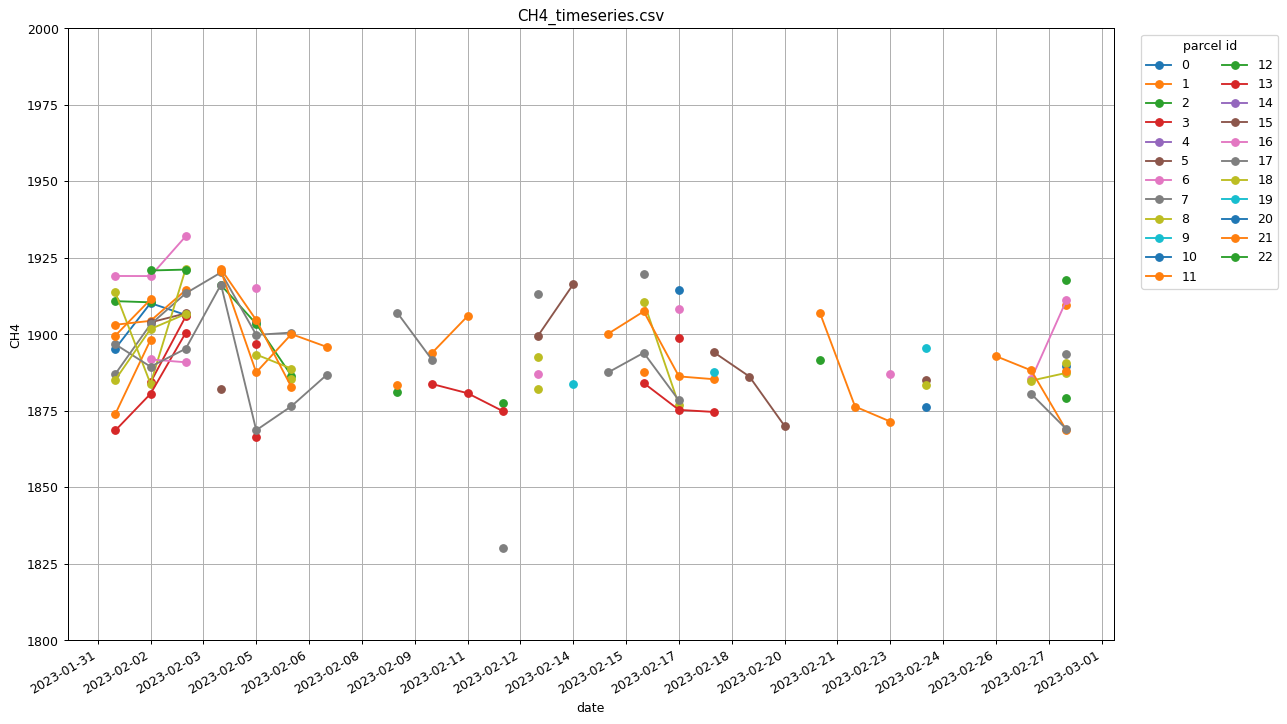

In [24]:
plot_timeseries("CH4-results/CH4_timeseries.csv")


In [ ]:
cube = connection.load_collection(
  collection_id='SENTINEL_5P_L2',
  temporal_extent=['2020-02-28', '2020-02-28'], # select the date you wish to view
  spatial_extent={'west': -5.360168, 'south': 38.320048, 'east': -3.040865, 'north': 40.02087, 'espg': 4326},
  bands=['CH4']
)

cube.execute_batch(outputfile='Sentinel5P_Spain.nc',
  title='Sentinel-5P Spain'
)

# https://dataspace.copernicus.eu/news/2023-9-28-accessing-sentinel-mission-data-new-copernicus-data-space-ecosystem-apis